### JIGGSAW TOXIC COMMENT CLASSIFICATION

### Importing Respective Packages

In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns

#nlp
import re
import nltk
import string
import numpy as np
import pandas as pd
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize   
from nltk.stem.wordnet import WordNetLemmatizer 

#FeatureEngineering and models, metrics
from sklearn import svm
from sklearn import tree
from sklearn import metrics
from scipy.sparse import hstack
from sklearn.metrics import log_loss
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc

### Intial settings

In [5]:
#settings
color = sns.color_palette()
sns.set_style("dark")
stop_words = set(stopwords.words("english"))

lem = WordNetLemmatizer()
snow = SnowballStemmer('english')

%matplotlib inline

### Data Loading

In [6]:
train = pd.read_csv(r"C:\Users\vutuk\OneDrive\Documents\ML PROJECT\train.csv")
test = pd.read_csv(r"C:\Users\vutuk\OneDrive\Documents\ML PROJECT\test.csv")


### NULL Check

In [7]:
train.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [8]:
test.isna().sum()

id              0
comment_text    0
dtype: int64

### Visualizations

In [9]:
#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)

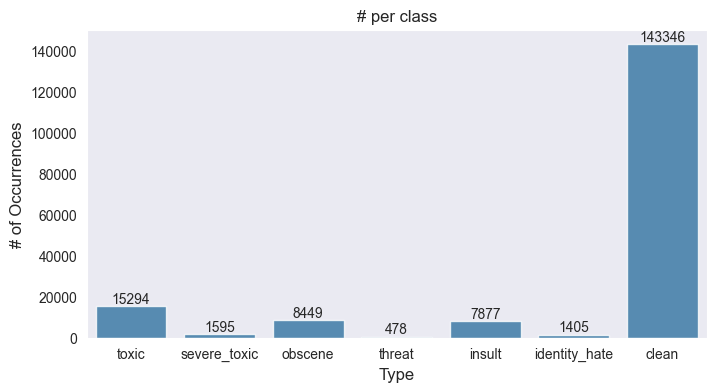

In [10]:

x=train.iloc[:,2:].sum()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha='center', va='bottom')

plt.show()

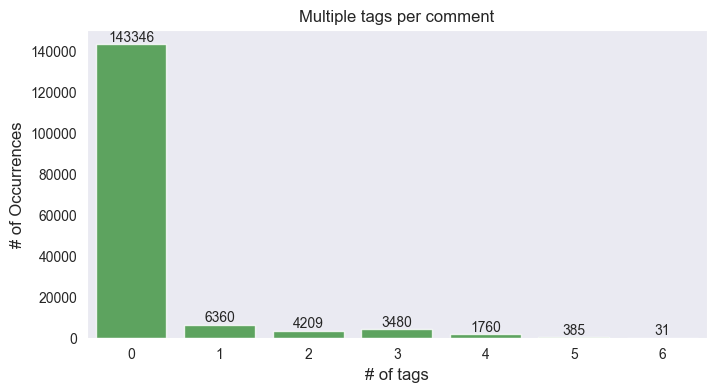

In [11]:
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8, color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

<Axes: >

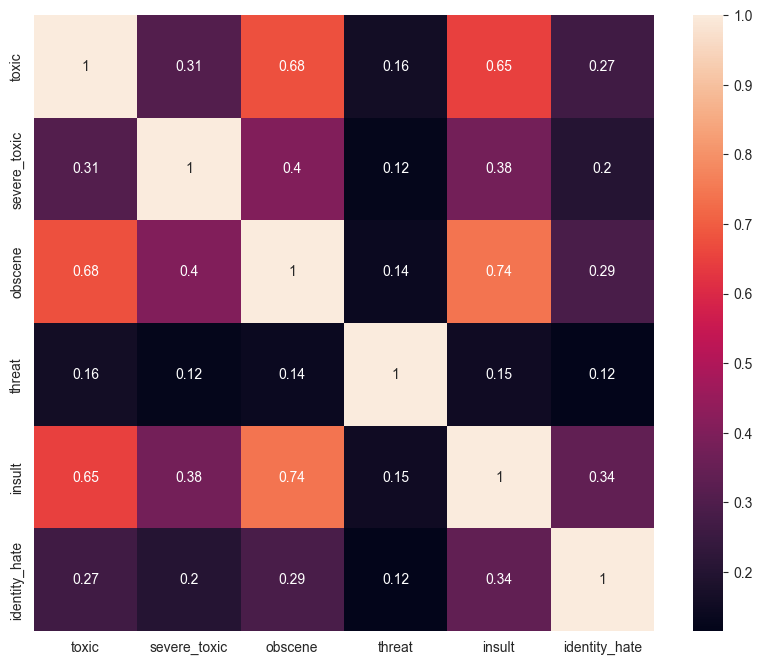

In [12]:
temp_df=train.iloc[:,2:-1]
corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

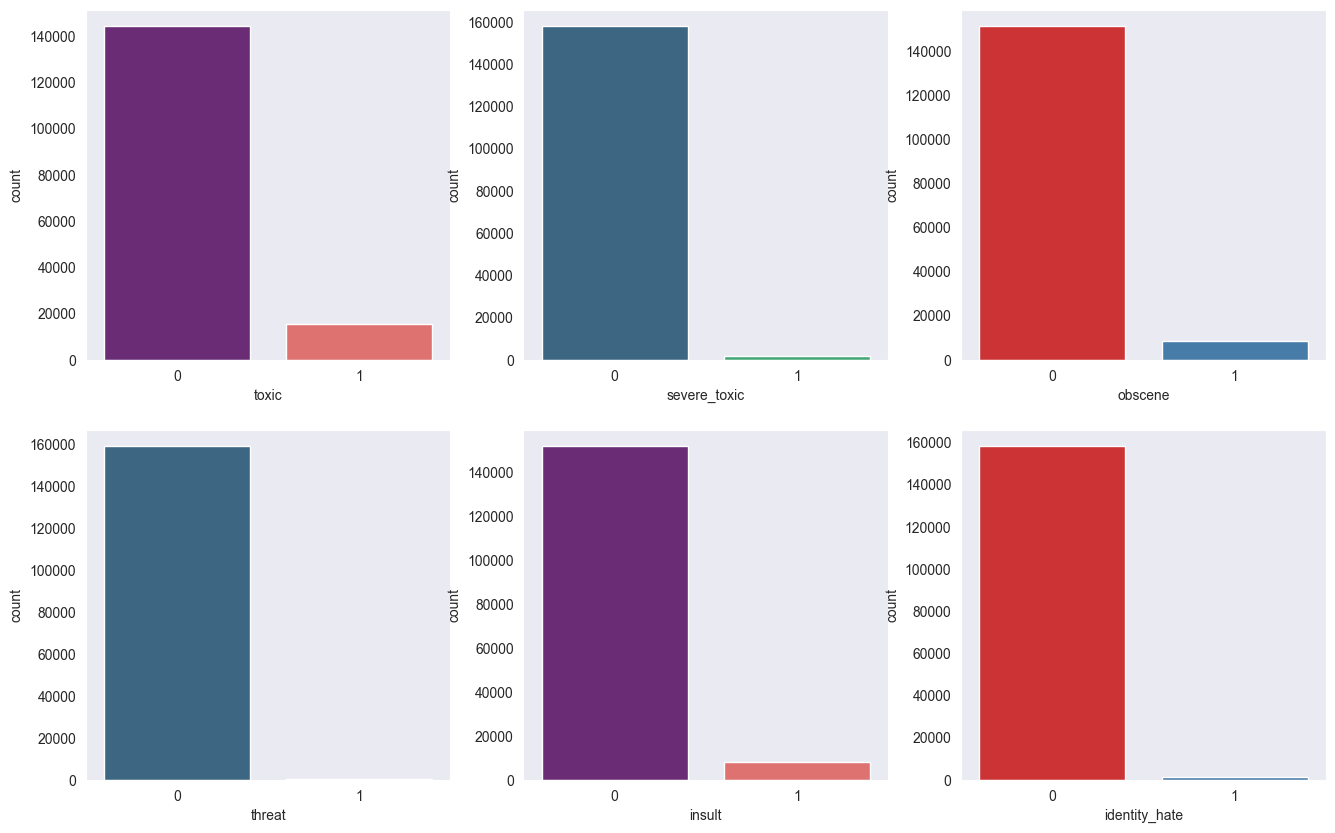

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(2, 3, figsize=(16, 10))
ax1, ax2, ax3, ax4, ax5, ax6 = ax.flatten()

sns.countplot(x=train['toxic'], palette='magma', ax=ax1, hue=train['toxic'], legend=False)
sns.countplot(x=train['severe_toxic'], palette='viridis', ax=ax2, hue=train['severe_toxic'], legend=False)
sns.countplot(x=train['obscene'], palette='Set1', ax=ax3, hue=train['obscene'], legend=False)
sns.countplot(x=train['threat'], palette='viridis', ax=ax4, hue=train['threat'], legend=False)
sns.countplot(x=train['insult'], palette='magma', ax=ax5, hue=train['insult'], legend=False)
sns.countplot(x=train['identity_hate'], palette='Set1', ax=ax6, hue=train['identity_hate'], legend=False)

plt.show()






### Feature Engineering

New Features from comment_text feature

In [14]:
#Sentences count
train['count_sent']=train["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1) # count sentences
#Word count
train['count_word']=train["comment_text"].apply(lambda x: len(str(x).split())) #count words
#Unique word count
train['count_unique_word']=train["comment_text"].apply(lambda x: len(set(str(x).split())))
#Letter count
train['count_letters']=train["comment_text"].apply(lambda x: len(str(x)))
#punctuation count
train["count_punctuations"] =train["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
train["count_words_upper"] = train["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
train["count_words_title"] = train["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
train["count_stopwords"] = train["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

#derived features
#Word count percent in each comment:
train['word_unique_percent']=train['count_unique_word']*100/train['count_word']
#Punct percent in each comment:
train['punct_percent']=train['count_punctuations']*100/train['count_word']

In [15]:
features = ('count_sent', 'count_word', 'count_unique_word', 'count_letters', 'count_punctuations', 'count_words_upper', 
            'count_words_title', 'count_stopwords', 'word_unique_percent','punct_percent')
columns = ('toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate')
rows = [{c:train[f].corr(train[c]) for c in columns} for f in features]
data_correlations = pd.DataFrame(rows, index=features)
data_correlations


,toxic,severe_toxic,obscene,threat,insult,identity_hate
count_sent,-0.010434,0.019784,-0.002749,-0.000248,-0.008845,0.002479
count_word,-0.052444,0.008452,-0.042207,-0.006688,-0.043642,-0.014493
count_unique_word,-0.096256,-0.048377,-0.080942,-0.020279,-0.080960,-0.032796
count_letters,-0.054470,0.010131,-0.042945,-0.008011,-0.045052,-0.013647
count_punctuations,-0.013491,0.038125,-0.013688,0.017624,-0.015782,-0.010583
count_words_upper,0.094123,0.145556,0.079580,0.039755,0.075260,0.046290
count_words_title,-0.053841,-0.006759,-0.043989,-0.004490,-0.046642,-0.019360
count_stopwords,-0.062358,-0.010675,-0.052419,-0.008111,-0.051788,-0.023537
word_unique_percent,0.056491,-0.027050,0.042755,-0.004020,0.043348,0.010632
punct_percent,0.014743,0.017668,0.008924,0.003360,0.008432,-0.000563


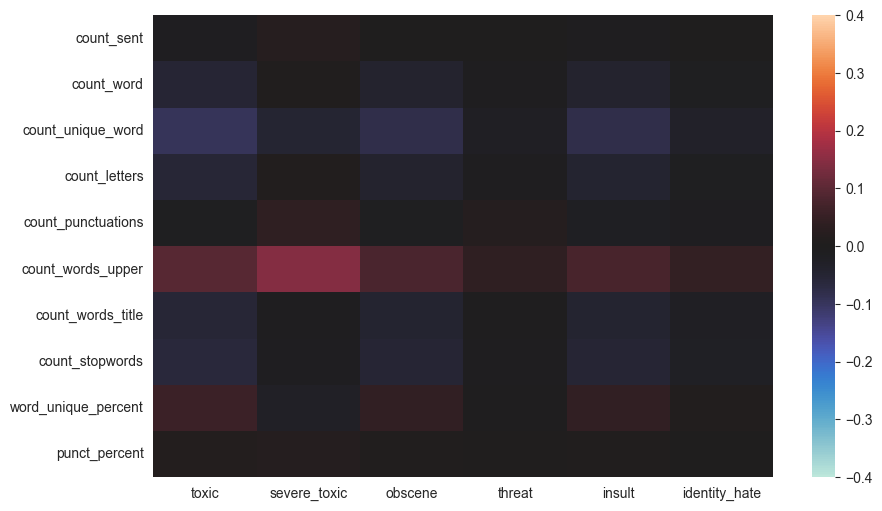

In [16]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(data_correlations, vmin=-0.4, vmax=0.4, center=0.0)

In [17]:
def remove_chars(text):
    return re.sub('[^a-zA-Z]+', ' ', text.encode('ascii',errors='ignore').decode().lower()).strip()

stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return ' '.join([x for x in text.split() if x not in stop_words])

def lemma(text):
    return ' '.join([lem.lemmatize(x) for x in text.split()])

def stemm(text):
    return ' '.join([snow.stem(x) for x in text.split()])

In [18]:
train['comment_text'] = train['comment_text'].apply(remove_chars)
# train['comment_text'] = train['comment_text'].apply(remove_stopwords)
# train['comment_text'] = train['comment_text'].apply(stemm)
# train['comment_text'] = train['comment_text'].apply(lemma)

test['comment_text'] = test['comment_text'].apply(remove_chars)
# test['comment_text'] = test['comment_text'].apply(remove_stopwords)
# test['comment_text'] = test['comment_text'].apply(stemm)
# test['comment_text'] = test['comment_text'].apply(lemma)

 Creating Corpus from dataset

In [19]:
all_text = pd.concat([train['comment_text'], test['comment_text']])

### Training and Testing models

Creating TFIDF word and character vectorizers

In [20]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{3,}',
    stop_words='english',
    ngram_range=(1, 4),
    max_features=20000)

word_vectorizer.fit(all_text)
train_features = word_vectorizer.transform(train['comment_text'])

Splitting Training data

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(train_features, 
                                                      train[list(columns)], test_size=0.30, random_state=2018)

### Logistic Regression Model using only word vectorizer


Model Training

In [22]:
Predicted = pd.DataFrame()

for i, class_name in enumerate(columns):
    classifier = LogisticRegression(C=2, solver='sag')
    classifier.fit(X_train, y_train[class_name])
    Predicted[class_name] = classifier.predict(X_valid)
    print("Logistic Regression model Fitted and Classified data for class: {}".format(class_name))

Logistic Regression model Fitted and Classified data for class: toxic
Logistic Regression model Fitted and Classified data for class: severe_toxic
Logistic Regression model Fitted and Classified data for class: obscene
Logistic Regression model Fitted and Classified data for class: threat
Logistic Regression model Fitted and Classified data for class: insult
Logistic Regression model Fitted and Classified data for class: identity_hate


Displaying Accuracy and Confusion matrix

In [23]:
for class_name in columns:
    print("Accuracy of {} : {}".format(class_name, metrics.accuracy_score(y_valid[class_name], Predicted[class_name])))
    print ("confusion_matrix of {} is: \n {}".format(class_name, confusion_matrix(y_valid[class_name], Predicted[class_name])))

Accuracy of toxic : 0.9583890374331551
confusion_matrix of toxic is: 
 [[42982   326]
 [ 1666  2898]]
Accuracy of severe_toxic : 0.9902448195187166
confusion_matrix of severe_toxic is: 
 [[47283    87]
 [  380   122]]
Accuracy of obscene : 0.9787349598930482
confusion_matrix of obscene is: 
 [[45166   175]
 [  843  1688]]
Accuracy of threat : 0.997305314171123
confusion_matrix of threat is: 
 [[47716    17]
 [  112    27]]
Accuracy of insult : 0.9699824532085561
confusion_matrix of insult is: 
 [[45186   315]
 [ 1122  1249]]
Accuracy of identity_hate : 0.9915817179144385
confusion_matrix of identity_hate is: 
 [[47382    48]
 [  355    87]]


Plotting AUC ROC curves

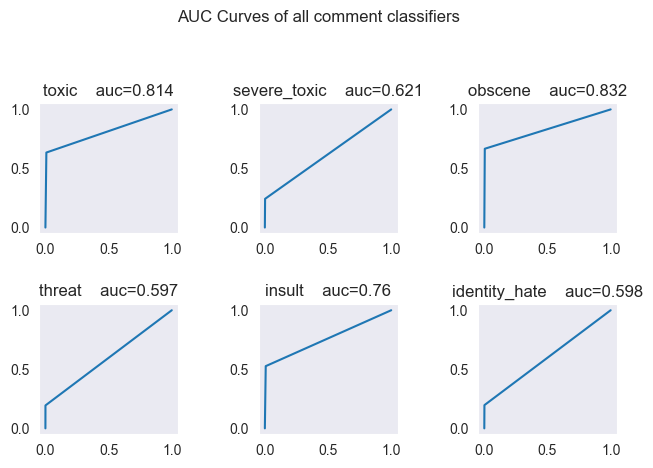

In [24]:
fig, axs = plt.subplots(2,3, figsize=(7, 5))
fig.suptitle('AUC Curves of all comment classifiers')
fig.tight_layout(pad=3.0)
axs = axs.ravel()

for i, class_name in enumerate(columns):
    fpr, tpr, _ = metrics.roc_curve(y_valid[class_name], Predicted[class_name])
    auc = round(metrics.roc_auc_score(y_valid[class_name], Predicted[class_name]), 3)
    axs[i].plot(fpr, tpr)
    axs[i].title.set_text(class_name+"    auc="+str(auc))

Displaying Cross value scores

In [25]:
scores = []

for class_name in columns:
    classifier = LogisticRegression(C=2, solver='sag')
    cv_score = np.mean(cross_val_score(classifier, train_features, train[class_name], cv=5, scoring='roc_auc'))
    scores.append(cv_score)
    print('Logistic Regression CV score for class {} is {}'.format(class_name, round(cv_score*100, 2)))
print('Total CV score is {}'.format(round(np.mean(scores)*100, 2)))

Logistic Regression CV score for class toxic is 96.84
Logistic Regression CV score for class severe_toxic is 98.26
Logistic Regression CV score for class obscene is 98.34
Logistic Regression CV score for class threat is 98.34
Logistic Regression CV score for class insult is 97.45
Logistic Regression CV score for class identity_hate is 97.18
Total CV score is 97.73


### Multinomial Naive Bayes Classifier with word and character vectorizer 

Model Training

In [26]:
Predicted = pd.DataFrame()

for i, class_name in enumerate(columns):
    classifier = MultinomialNB()
    classifier.fit(X_train, y_train[class_name])
    Predicted[class_name] = classifier.predict(X_valid)
    print("MultiNomialNB Fitted and Classified data for class: {}".format(class_name))

MultiNomialNB Fitted and Classified data for class: toxic
MultiNomialNB Fitted and Classified data for class: severe_toxic
MultiNomialNB Fitted and Classified data for class: obscene
MultiNomialNB Fitted and Classified data for class: threat
MultiNomialNB Fitted and Classified data for class: insult
MultiNomialNB Fitted and Classified data for class: identity_hate


Displaying Accuracy and Confusion matrix

In [27]:
for class_name in columns:
    print("Accuracy of {} : {}".format(class_name, metrics.accuracy_score(y_valid[class_name], Predicted[class_name])))
    print ("confusion_matrix of {} is: \n{}".format(class_name, confusion_matrix(y_valid[class_name], Predicted[class_name])))

Accuracy of toxic : 0.9480907419786097
confusion_matrix of toxic is: 
[[43159   149]
 [ 2336  2228]]
Accuracy of severe_toxic : 0.9831007687165776
confusion_matrix of severe_toxic is: 
[[46992   378]
 [  431    71]]
Accuracy of obscene : 0.9659508689839572
confusion_matrix of obscene is: 
[[45055   286]
 [ 1344  1187]]
Accuracy of threat : 0.9900985962566845
confusion_matrix of threat is: 
[[47398   335]
 [  139     0]]
Accuracy of insult : 0.9612508355614974
confusion_matrix of insult is: 
[[45122   379]
 [ 1476   895]]
Accuracy of identity_hate : 0.9836438836898396
confusion_matrix of identity_hate is: 
[[47063   367]
 [  416    26]]


Plotting AUC ROC curves

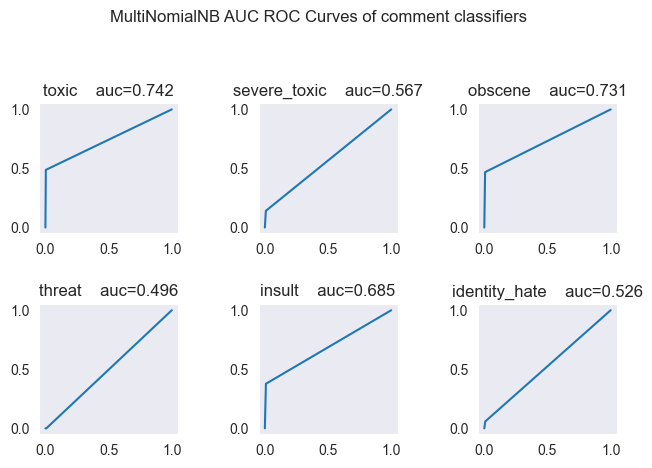

In [28]:
fig, axs = plt.subplots(2,3, figsize=(7, 5))
fig.suptitle('MultiNomialNB AUC ROC Curves of comment classifiers')
fig.tight_layout(pad=3.0)
axs = axs.ravel()

for i, class_name in enumerate(columns):
    fpr, tpr, _ = metrics.roc_curve(y_valid[class_name], Predicted[class_name])
    auc = round(metrics.roc_auc_score(y_valid[class_name], Predicted[class_name]), 3)
    axs[i].plot(fpr, tpr)
    axs[i].title.set_text(class_name+"    auc="+str(auc))

Displaying Cross value scores

In [29]:
scores = []

for class_name in columns:
    classifier = MultinomialNB()
    cv_score = np.mean(cross_val_score(classifier, train_features, train[class_name], cv=5, scoring='roc_auc'))
    scores.append(cv_score)
    print('MultiNomialNB Classifier CV score for class {} is {}'.format(class_name, round(cv_score*100, 2)))
print('MultiNomialNB Classifier Total CV score is {}'.format(round(np.mean(scores)*100, 2)))

MultiNomialNB Classifier CV score for class toxic is 95.08
MultiNomialNB Classifier CV score for class severe_toxic is 94.94
MultiNomialNB Classifier CV score for class obscene is 95.36
MultiNomialNB Classifier CV score for class threat is 88.24
MultiNomialNB Classifier CV score for class insult is 94.92
MultiNomialNB Classifier CV score for class identity_hate is 90.86
MultiNomialNB Classifier Total CV score is 93.23


### SGD Classifier with word and character vectorizer

Model Training

In [30]:
Predicted = pd.DataFrame()

for i, class_name in enumerate(columns):
    classifier = SGDClassifier(loss="hinge", penalty="l2", max_iter=100)
    classifier.fit(X_train, y_train[class_name])
    Predicted[class_name] = classifier.predict(X_valid)
    print("SGD Classifier model Fitted and Classified data for class: {}".format(class_name))

SGD Classifier model Fitted and Classified data for class: toxic
SGD Classifier model Fitted and Classified data for class: severe_toxic
SGD Classifier model Fitted and Classified data for class: obscene
SGD Classifier model Fitted and Classified data for class: threat
SGD Classifier model Fitted and Classified data for class: insult
SGD Classifier model Fitted and Classified data for class: identity_hate


In [31]:
for class_name in columns:
    print("Accuracy of {} : {}".format(class_name, metrics.accuracy_score(y_valid[class_name], Predicted[class_name])))
    print ("confusion_matrix of {} is: \n {}".format(class_name, confusion_matrix(y_valid[class_name], Predicted[class_name])))

Accuracy of toxic : 0.9469418449197861
confusion_matrix of toxic is: 
 [[43210    98]
 [ 2442  2122]]
Accuracy of severe_toxic : 0.9895137032085561
confusion_matrix of severe_toxic is: 
 [[47370     0]
 [  502     0]]
Accuracy of obscene : 0.9762282754010695
confusion_matrix of obscene is: 
 [[45240   101]
 [ 1037  1494]]
Accuracy of threat : 0.9970964237967914
confusion_matrix of threat is: 
 [[47733     0]
 [  139     0]]
Accuracy of insult : 0.9677055481283422
confusion_matrix of insult is: 
 [[45281   220]
 [ 1326  1045]]
Accuracy of identity_hate : 0.9908923796791443
confusion_matrix of identity_hate is: 
 [[47430     0]
 [  436     6]]


Plotting AUC ROC curves

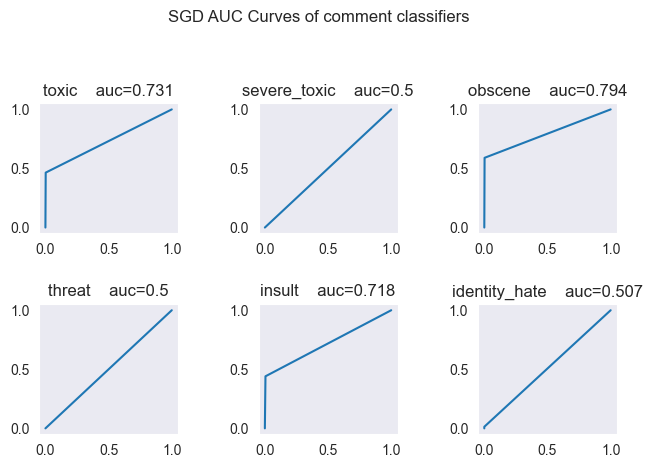

In [32]:
fig, axs = plt.subplots(2,3, figsize=(7, 5))
fig.suptitle('SGD AUC Curves of comment classifiers')
fig.tight_layout(pad=3.0)
axs = axs.ravel()

for i, class_name in enumerate(columns):
    fpr, tpr, _ = metrics.roc_curve(y_valid[class_name], Predicted[class_name])
    auc = round(metrics.roc_auc_score(y_valid[class_name], Predicted[class_name]), 3)
    axs[i].plot(fpr, tpr)
    axs[i].title.set_text(class_name+"    auc="+str(auc))

In [33]:
scores = []

for class_name in columns:
    classifier = SGDClassifier(loss="hinge", penalty="l2", max_iter=100)
    cv_score = np.mean(cross_val_score(classifier, train_features, train[class_name], cv=5, scoring='roc_auc'))
    scores.append(cv_score)
    print('SGD CV score for class {} is {}'.format(class_name, round(cv_score*100, 2)))
print('SGD Total CV score is {}'.format(round(np.mean(scores)*100, 2)))

SGD CV score for class toxic is 96.25
SGD CV score for class severe_toxic is 95.21
SGD CV score for class obscene is 97.95
SGD CV score for class threat is 96.75
SGD CV score for class insult is 96.66
SGD CV score for class identity_hate is 94.64
SGD Total CV score is 96.24


### Adaboost Classifier with word and character vectorizer

Model Training

In [38]:
'''Predicted = pd.DataFrame()

for i, class_name in enumerate(columns):
    classifier = AdaBoostClassifier(n_estimators=100, random_state=0)
    classifier.fit(X_train, y_train[class_name])
    Predicted[class_name] = classifier.predict(X_valid)
    print("Adaboost Classifier model Fitted and Classified data for class: {}".format(class_name))'''
Predicted = pd.DataFrame()

for i, class_name in enumerate(columns):
    classifier = AdaBoostClassifier(n_estimators=100, random_state=0, algorithm='SAMME')
    classifier.fit(X_train, y_train[class_name])
    Predicted[class_name] = classifier.predict(X_valid)
    print("Adaboost Classifier model Fitted and Classified data for class: {}".format(class_name))

Adaboost Classifier model Fitted and Classified data for class: toxic
Adaboost Classifier model Fitted and Classified data for class: severe_toxic
Adaboost Classifier model Fitted and Classified data for class: obscene
Adaboost Classifier model Fitted and Classified data for class: threat
Adaboost Classifier model Fitted and Classified data for class: insult
Adaboost Classifier model Fitted and Classified data for class: identity_hate


Displaying Accuracy and Confusion matrix

In [39]:
for class_name in columns:
    print("Accuracy of {} : {}".format(class_name, metrics.accuracy_score(y_valid[class_name], Predicted[class_name])))
    print ("confusion_matrix of {} is: \n {}".format(class_name, confusion_matrix(y_valid[class_name], Predicted[class_name])))

Accuracy of toxic : 0.9226478943850267
confusion_matrix of toxic is: 
 [[43271    37]
 [ 3666   898]]
Accuracy of severe_toxic : 0.9895345922459893
confusion_matrix of severe_toxic is: 
 [[47309    61]
 [  440    62]]
Accuracy of obscene : 0.9637575200534759
confusion_matrix of obscene is: 
 [[45304    37]
 [ 1698   833]]
Accuracy of threat : 0.9970546457219251
confusion_matrix of threat is: 
 [[47727     6]
 [  135     4]]
Accuracy of insult : 0.9587441510695187
confusion_matrix of insult is: 
 [[45303   198]
 [ 1777   594]]
Accuracy of identity_hate : 0.9908923796791443
confusion_matrix of identity_hate is: 
 [[47425     5]
 [  431    11]]


Plotting AUC ROC curves

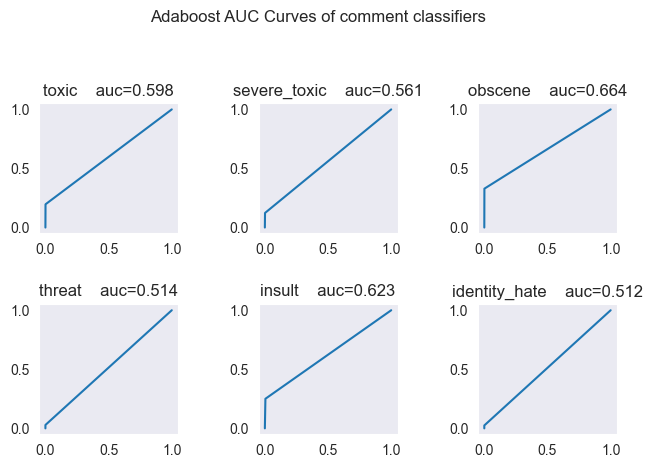

In [40]:
fig, axs = plt.subplots(2,3, figsize=(7, 5))
fig.suptitle('Adaboost AUC Curves of comment classifiers')
fig.tight_layout(pad=3.0)
axs = axs.ravel()

for i, class_name in enumerate(columns):
    fpr, tpr, _ = metrics.roc_curve(y_valid[class_name], Predicted[class_name])
    auc = round(metrics.roc_auc_score(y_valid[class_name], Predicted[class_name]), 3)
    axs[i].plot(fpr, tpr)
    axs[i].title.set_text(class_name+"    auc="+str(auc))

Displaying Cross value scores

In [42]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

scores = []

for class_name in columns:
    classifier = AdaBoostClassifier(n_estimators=100, random_state=0, algorithm='SAMME')
    cv_score = np.mean(cross_val_score(classifier, train_features, train[class_name], cv=5, scoring='roc_auc'))
    scores.append(cv_score)
    print('Adaboost CV score for class {} is {}'.format(class_name, round(cv_score*100, 2)))
print('Adaboost Total CV score is {}'.format(round(np.mean(scores)*100, 2)))


Adaboost CV score for class toxic is 80.37
Adaboost CV score for class severe_toxic is 95.1
Adaboost CV score for class obscene is 88.6
Adaboost CV score for class threat is 92.6
Adaboost CV score for class insult is 86.4
Adaboost CV score for class identity_hate is 89.13
Adaboost Total CV score is 88.7
